# Spark Data Analytics Playground <br>
### A project by Albert Hunduza

## Part 1: Basic Operations on Resilient Distributed Datasets (RDDs)

#### In this section we will attempt to answer this question:

![Basic Operations](part1.png)


In [1]:
# import SparkContext from PySpark module
from pyspark import SparkContext
sc = SparkContext("local", "RDDOperations")# creates SparkContext
print('SparkContext:', sc) # prints configuration of SparkContext

23/08/22 09:40:48 WARN Utils: Your hostname, albert resolves to a loopback address: 127.0.1.1; using 192.168.0.170 instead (on interface wlp5s0)
23/08/22 09:40:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/22 09:40:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


SparkContext: <SparkContext master=local appName=RDDOperations>


### 1) Creating RDDs

* we start by creating the RDDs with the lists of words using the parallelize() function

In [2]:
a = sc.parallelize(["spark", "rdd", "python", "context", "create", "class"]) # creates RDD of a
b = sc.parallelize(["operation", "apache", "scala", "lambda","parallel","partition"]) # creates RDD of b

### 2) Performing Joins

* In order to retain the words (not letters) after joining,  we map each word to a count, and since there is just one instance of each distinct word, they all get a count of 1

In [3]:
# mapping words to counts
a_counts = a.map(lambda x: (x, 1)) #  maps each word to a count
b_counts = b.map(lambda x: (x, 1)) # maps each word to a count

In [4]:
right_outer_joined = a_counts.rightOuterJoin(b_counts) # performs right outer join
print('Right outer join of a and b gives:', right_outer_joined.collect())

Right outer join of a and b gives: [('scala', (None, 1)), ('parallel', (None, 1)), ('partition', (None, 1)), ('operation', (None, 1)), ('apache', (None, 1)), ('lambda', (None, 1))]


* The right outer join returns all matching rows and rows from the RDD on the right. Since there were no matching rows between the 2 RDDs, it returned all the values from the RDD on the right <br>
  and null values for the left RDD

In [5]:
full_outer_joined = a_counts.fullOuterJoin(b_counts) # performs full outer join
print('Full outer join of a and b gives:', full_outer_joined.collect())

Full outer join of a and b gives: [('python', (1, None)), ('class', (1, None)), ('scala', (None, 1)), ('parallel', (None, 1)), ('partition', (None, 1)), ('spark', (1, None)), ('rdd', (1, None)), ('context', (1, None)), ('create', (1, None)), ('operation', (None, 1)), ('apache', (None, 1)), ('lambda', (None, 1))]


* The full outer join returns all matching rows, and all rows from both the left and right RDDs. This is why it returned all values from both datasets with null values to represent the <br>
  opposite RDD in each case since there were no matching rows

### 3) Counting Characters

* to count the number of appearances of 's' from both RDDs, we combine the RDDs using a union function. We then separate each word into letters and group all the letters in one list. <br>
  Next, we filter out the 's' s into a list of their own

In [6]:
a_b = a.union(b) # combines a and b 
letters = a_b.flatMap(lambda x: list(x)) # gets list of all letters in a and b
s_list = letters.filter(lambda x: x =='s') # filters all the "s"s

In [7]:
# using map and reduce
s_list.map(lambda x: (x, 1)).reduceByKey(lambda x,y:x+y).collect()

[('s', 4)]

In [8]:
# using count (aggregate function)
print("Number of times 's' appears is: ", s_list.count()) # counts "s"s and prints

Number of times 's' appears is:  4


* both the aggregate function, and the count function get a result of 4 corroborating each other

## Part B: Basic Operations on DataFrames

#### For this section we will attempt to answer this question using a Dataframe created using the students.json dataset:

![DataFrames](part2.png)

In [9]:
# importing necessary packages

from pyspark.sql import SparkSession # necessary package to start session
import pyspark.sql.functions as F # necessary parkage to perform operations
spark = SparkSession.builder.master('local[1]').appName('JSON loader').getOrCreate() # creates session
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY") # bypasses error caused by new version of pyspark

DataFrame[key: string, value: string]

* we start by reading in the dataset

In [10]:
students_df = spark.read.json(r'students.json') # reads json file
students_df.show(5) # prints dataframe

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
+------------------+------------------+----------+---------+------+----+
only showing top 5 rows



* After reading in the DataFrame, we can print its schema in order to understand its datatypes better

In [11]:
students_df.printSchema() # prints schema

root
 |-- course: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- points: long (nullable = true)
 |-- s_id: long (nullable = true)



* we can also use the describe function to get a summary function, and perhaps more conveniently, get the mean and standard deviation which are required in the next phase

In [12]:
students_df.describe().show() # prints summary of dataframe

23/08/22 09:41:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------+------------------+----------+---------+------------------+-----------------+
|summary|    course|               dob|first_name|last_name|            points|             s_id|
+-------+----------+------------------+----------+---------+------------------+-----------------+
|  count|        20|                19|        20|       18|                19|               20|
|   mean|      null|              null|      null|     null|11.736842105263158|             10.5|
| stddev|      null|              null|      null|     null|3.3307007147839007|5.916079783099616|
|    min|  Business|    1 January 1984|      Alan|  Ballard|                 6|                1|
|    max|Psychology|September 26, 1980|   Zachary|    Weber|                19|               20|
+-------+----------+------------------+----------+---------+------------------+-----------------+



### 1) Cleaning the DataFrame

* To clean the data, we start by filling in all the null values. We fill in the null values in the points column with the mean of 12 which we obtained from above.<br>
 Note: We round up to 12 here since all the other figures for points are whole numbers 

In [13]:
students_df_fill_points = students_df.na.fill({'points': 12}) # fills null values in points column
students_df_fill_points.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|     null|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

* Next, we fill the null values in the other columns using the prescribed words and symbols

In [14]:
students_df_fill_string = students_df_fill_points.na.fill({'dob': 'unkown', 'last_name': '--'}) # fills null values in dob and last_name columns
students_df_fill_string.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|       --|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

* moving on, we can reformat the 'dob' column to use one consistent format

In [19]:
students_df_date_reformatted = students_df_fill_string.withColumn(
    "dob",
    F.when(
        F.to_date(F.col("dob"), "MMMM dd, yyyy").isNotNull(),
        F.to_date(F.col("dob"), "MMMM dd, yyyy")  # for date with format 'October 14, 1983'
    ).otherwise(
        F.when(
            F.to_date(F.col("dob"), "dd MMMM yy").isNotNull(),
            F.to_date(F.col("dob"), "dd MMMM yy")  # for date with format '30 December 1987'
        )
    )
)

students_df_date_reformatted = students_df_date_reformatted.withColumn("dob", F.date_format(F.to_date("dob", "dd MMM yyyy"), "dd-MM-yyyy"))  # reformats new date to 'DD-MM-YYYY'

# Replace null values created in above operations in "dob" column with 'unknown'
students_df_date_reformatted = students_df_date_reformatted.withColumn("dob", F.when(F.col("dob").isNull(), "unknown").otherwise(F.col("dob")))

students_df_date_reformatted.show(5)

+------------------+----------+----------+---------+------+----+
|            course|       dob|first_name|last_name|points|s_id|
+------------------+----------+----------+---------+------+----+
|Humanities and Art|14-10-1983|      Alan|      Joe|    10|   1|
|  Computer Science|26-09-1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|12-06-1982|     Athur|   Watson|    16|   3|
|    Graphic Design|05-04-1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|01-11-1978|      Kira| Schommer|    11|   5|
+------------------+----------+----------+---------+------+----+
only showing top 5 rows



### 2) Adding an 'age' column

* we can calculate the age of the students by calculating the number of months from their dates of births to the the current date, and then dividing by 12 to get their age in years

In [31]:
# calculate student age in months
students_df_with_months = students_df_date_reformatted.withColumn('age_in_months', F.months_between(F.current_date(), F.to_date(F.col('dob'), 'dd-MM-yyyy')))

# Calculate age in years and store as a whole integer in 'age' column
students_df_with_age = students_df_with_months.withColumn('age', (F.col('age_in_months') / 12).cast('int')).drop('age_in_months')

# Change null values in 'age' column to 'unknown'
students_df_with_age = students_df_with_age.withColumn('age', F.when(F.col('age').isNull(), 'unknown').otherwise(F.col('age')))

# Show the DataFrame
students_df_with_age.show()

+------------------+----------+----------+---------+------+----+-------+
|            course|       dob|first_name|last_name|points|s_id|    age|
+------------------+----------+----------+---------+------+----+-------+
|Humanities and Art|14-10-1983|      Alan|      Joe|    10|   1|     39|
|  Computer Science|26-09-1980|    Martin|  Genberg|    17|   2|     42|
|    Graphic Design|12-06-1982|     Athur|   Watson|    16|   3|     41|
|    Graphic Design|05-04-1987|  Anabelle|  Sanberg|    12|   4|     36|
|        Psychology|01-11-1978|      Kira| Schommer|    11|   5|     44|
|          Business|17-02-1981| Christian|   Kiriam|    10|   6|     42|
|  Machine Learning|01-01-1984|   Barbara|  Ballard|    14|   7|     39|
|     Deep Learning|13-01-1978|      John|       --|    10|   8|     45|
|  Machine Learning|26-12-1989|    Marcus|   Carson|    15|   9|     33|
|           Physics|30-12-1987|     Marta|   Brooks|    11|  10|     35|
|    Data Analytics|12-06-1975|     Holly| Schwartz

* once again, we can use the describe function to get a summary of the data and the values for mean and standard deviation which will be required later

In [32]:
students_df_with_age.describe().show() # prints summary

+-------+----------+----------+----------+---------+------------------+-----------------+------------------+
|summary|    course|       dob|first_name|last_name|            points|             s_id|               age|
+-------+----------+----------+----------+---------+------------------+-----------------+------------------+
|  count|        20|        20|        20|       20|                20|               20|                20|
|   mean|      null|      null|      null|     null|             11.75|             10.5|39.473684210526315|
| stddev|      null|      null|      null|     null|3.2424000207773322|5.916079783099616| 4.194817186489796|
|    min|  Business|01-01-1984|      Alan|       --|                 6|                1|                32|
|    max|Psychology|   unknown|   Zachary|    Weber|                19|               20|           unknown|
+-------+----------+----------+----------+---------+------------------+-----------------+------------------+



### 3) Rewarding well-performing students

* We use the prescribed conditions to update the points column. Since the mean is 11.75 and the standard deviation was 3.24, we increase all students with 15 points (1 stddev higher than <br>  the mean) to 20

In [34]:
students_df_final = students_df_with_age.withColumn("points", F.when(students_df_with_age.points >= 15, 20).otherwise(students_df_with_age.points)) # updates points conditionally
students_df_final.show()

+------------------+----------+----------+---------+------+----+-------+
|            course|       dob|first_name|last_name|points|s_id|    age|
+------------------+----------+----------+---------+------+----+-------+
|Humanities and Art|14-10-1983|      Alan|      Joe|    10|   1|     39|
|  Computer Science|26-09-1980|    Martin|  Genberg|    20|   2|     42|
|    Graphic Design|12-06-1982|     Athur|   Watson|    20|   3|     41|
|    Graphic Design|05-04-1987|  Anabelle|  Sanberg|    12|   4|     36|
|        Psychology|01-11-1978|      Kira| Schommer|    11|   5|     44|
|          Business|17-02-1981| Christian|   Kiriam|    10|   6|     42|
|  Machine Learning|01-01-1984|   Barbara|  Ballard|    14|   7|     39|
|     Deep Learning|13-01-1978|      John|       --|    10|   8|     45|
|  Machine Learning|26-12-1989|    Marcus|   Carson|    20|   9|     33|
|           Physics|30-12-1987|     Marta|   Brooks|    11|  10|     35|
|    Data Analytics|12-06-1975|     Holly| Schwartz

* To finish this part, we use the Matplotlib library to plot the histogram of points. We achieve this by first turning the points column into a Pandas list and then plotting it.

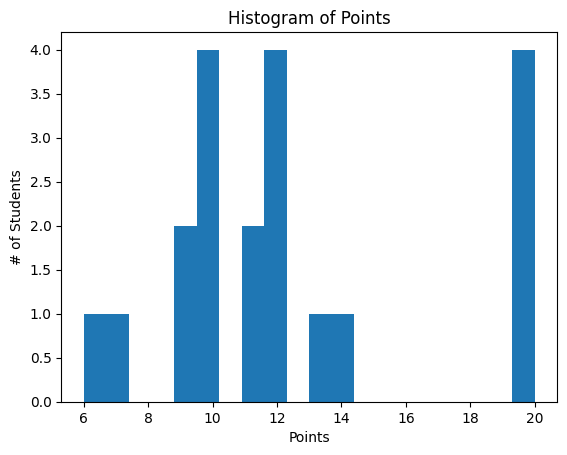

In [35]:
import matplotlib.pyplot as plt # necessary for plotting
points = students_df_final.toPandas()['points'].values.tolist() # creates list of points

plt.hist(points, bins=20) # plots histogram
plt.title('Histogram of Points')
plt.xlabel('Points')
plt.ylabel('# of Students')
plt.show()

## Part C: Manipulating Recommender Dataset using Apache Spark

#### Finally, we will attempt to answer this question:

![Recommender](part3.png)

* we start by reading in the .dat file

In [36]:
tags_df = spark.read.option('header', 'False') \
    .option('delimiter', '::') \
    .option('inferSchema', 'True') \
    .csv(r'tags.dat') \
    .toDF('UserID', 'MovieID', 'Tag', 'Timestamp')  # sets column names

tags_df.show()

+------+-------+--------------------+----------+
|UserID|MovieID|                 Tag| Timestamp|
+------+-------+--------------------+----------+
|    15|   4973|          excellent!|1215184630|
|    20|   1747|            politics|1188263867|
|    20|   1747|              satire|1188263867|
|    20|   2424|     chick flick 212|1188263835|
|    20|   2424|               hanks|1188263835|
|    20|   2424|                ryan|1188263835|
|    20|   2947|              action|1188263755|
|    20|   2947|                bond|1188263756|
|    20|   3033|               spoof|1188263880|
|    20|   3033|           star wars|1188263880|
|    20|   7438|              bloody|1188263801|
|    20|   7438|             kung fu|1188263801|
|    20|   7438|           Tarantino|1188263801|
|    21|  55247|                   R|1205081506|
|    21|  55253|               NC-17|1205081488|
|    25|     50|        Kevin Spacey|1166101426|
|    25|   6709|         Johnny Depp|1162147221|
|    31|     65|    

* The first task in this exercise is to separate the tagging sessions for each user. We can approach this in the following steps: <br>
<br>
  <sp> 1) reorder the  rows by Timestamps in ascending order to get chronology (this is within the main ordering by UserID which was already performed) <br>
  <sp> 2) create an offset column of the Timestamps to use in the next step <br>
  <sp> 3) subtract the Current Timestamp from the previous one (offset from above) to get the gap between tags <br>
  <sp> 4) create a new column for the "SessionIDs" <br>
  <sp> 5) create an offset column of the Timestamps to use in the next step <br>
  <sp> 6) reset the SessionID to 1 whenever a new UserID is encountered <br>
  <sp> 7) increase the SessionID by one whenever there is a Timestamp diffrence greater than or equal to 1800 (60 seconds * 30 minutes) whithin a particular UserID window <br>
  <sp> 8) keep the SessionID within a UserID window constant if the condition above is not met <br>

In [37]:
from pyspark.sql.window import Window

tags_df = tags_df.withColumn("SessionID",F.lag("Timestamp").over(Window.partitionBy("UserID").orderBy("Timestamp"))) # offsets timestamp by one row downwards
tags_df = tags_df.withColumn("SessionID",F.when(F.col("Timestamp") - F.col("SessionID") <= 1800, 0).otherwise(1)) # assigns a SessionID of 1 to every new UserID
tags_df = tags_df.withColumn("SessionID", F.sum("SessionID").over(Window.partitionBy("UserID").orderBy("Timestamp"))) # increases SessionID by 1 if Timestamp difference greater than 1800
tags_df.show(10)

+------+-------+---------------+----------+---------+
|UserID|MovieID|            Tag| Timestamp|SessionID|
+------+-------+---------------+----------+---------+
|    15|   4973|     excellent!|1215184630|        1|
|    20|   2947|         action|1188263755|        1|
|    20|   2947|           bond|1188263756|        1|
|    20|   7438|         bloody|1188263801|        1|
|    20|   7438|        kung fu|1188263801|        1|
|    20|   7438|      Tarantino|1188263801|        1|
|    20|   2424|chick flick 212|1188263835|        1|
|    20|   2424|          hanks|1188263835|        1|
|    20|   2424|           ryan|1188263835|        1|
|    20|   1747|       politics|1188263867|        1|
+------+-------+---------------+----------+---------+
only showing top 10 rows



* The next task was to calculate the frequncy of tagging for each user session. I interprated this to mean the number of tags per session for each user. <br>
* I calculated this by Grouping the DataFrame from above by both the UserID and the SessionID. This gave the result shown above

In [38]:
tags_per_session = tags_df.groupBy('UserID', 'SessionID').count() # calculates tags per session
tags_per_session.show(10)

+------+---------+-----+
|UserID|SessionID|count|
+------+---------+-----+
|    15|        1|    1|
|    20|        1|   12|
|    21|        1|    2|
|    25|        1|    1|
|    25|        2|    1|
|    31|        1|    5|
|    32|        1|    1|
|    39|        1|    5|
|    48|        1|    2|
|    49|        1|   15|
+------+---------+-----+
only showing top 10 rows



In [44]:
avg_tags_per_session = tags_per_session.groupBy('UserID').mean('count') # calculates avg tags per session per user
avg_tags_per_session.distinct().show()

+------+------------------+
|UserID|        avg(count)|
+------+------------------+
|    15|               1.0|
|    20|              12.0|
|    21|               2.0|
|    25|               1.0|
|    31|               5.0|
|    32|               1.0|
|    39|               5.0|
|    48|               2.0|
|    49|              15.0|
|    75|               1.0|
|    78|               1.0|
|   109|2.7777777777777777|
|   127|              26.0|
|   133|               5.0|
|   146| 4.948948948948949|
|   170|               1.0|
|   175|               1.0|
|   181|               4.0|
|   190|               6.5|
|   222|               1.0|
+------+------------------+
only showing top 20 rows



In [47]:
from pyspark.sql.functions import stddev
std_tags_per_session = tags_per_session.groupBy('UserID').agg(stddev('count')) # calculates the standard deviation per session per user
std_tags_per_session.show()

+------+------------------+
|UserID|stddev_samp(count)|
+------+------------------+
|    15|              null|
|    20|              null|
|    21|              null|
|    25|               0.0|
|    31|              null|
|    32|              null|
|    39|              null|
|    48|              null|
|    49|              null|
|    75|              null|
|    78|              null|
|   109|3.2702361450580977|
|   127|              null|
|   133|              null|
|   146| 9.010056652425451|
|   170|              null|
|   175|               0.0|
|   181|              null|
|   190|               7.0|
|   222|              null|
+------+------------------+
only showing top 20 rows



*NB: some users have a standard deviation of zero signifying that there is either only one value for that user or not enough variability in their tagging sessions to calculate a meaningful standard deviation*

* The next step is to perform the same calculations, albeit this time across across users
* We do this by getting the description (summary) of the table we created abouve with counts tags per session per user
* This gives us the results across users

In [41]:
tags_per_session.describe().show() # prints summary statistics

+-------+------------------+------------------+-----------------+
|summary|            UserID|         SessionID|            count|
+-------+------------------+------------------+-----------------+
|  count|             13093|             13093|            13093|
|   mean|31934.146872374553| 58.05315817612465|7.300084014358817|
| stddev|20629.693282234624|140.18873484729968|22.26429305026498|
|    min|                15|                 1|                1|
|    max|             71556|               891|              531|
+-------+------------------+------------------+-----------------+



* From the results above we can see that the mean is *7.300084014358817* tags per session and the standard deviation is *22.26429305026498*

In [42]:
avg = 7.300084014358817
std = 22.26429305026498
upper_bound = avg + 2 * std
lower_bound = avg - 2 *std

print('Upper Bound:', upper_bound)
print('Lower Bound:', lower_bound)

Upper Bound: 51.82867011488877
Lower Bound: -37.22850208617114


* We can then use these results to perform the final task which is to list all the Users with a tagging frequency within 2 standard deviations of the mean.
* This means setting a lower and upper bound from the mean. We add 2 times the std to the mean and also subtracted the same respectively.
* This means that we use an upper bound of 51.82867011488877, and a lower bound of 0 since Users can not tag a negative amount of times
* We filterer out all the Users with a tagging frequency within this range and saved them in a Pandas list

In [48]:
filtered_tags_per_session = avg_tags_per_session.filter(F.col('avg(count)') <= upper_bound)
user_list = filtered_tags_per_session.toPandas()['UserID']
print('List of users is within 2 stds of mean: \n', user_list)

List of users is within 2 stds of mean: 
 0          15
1          20
2          21
3          25
4          31
        ...  
3957    70243
3958    70642
3959    70645
3960    70899
3961    71155
Name: UserID, Length: 3962, dtype: int32


# End